# Draft of H3 evaluation
grid-cell wise comparison of metrics

In [1]:
%load_ext watermark
%watermark

Last updated: 2024-12-10T12:18:43.798741+01:00

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.26.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit



In [8]:
import os
import pathlib

import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import momepy as mm
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import gaussian_kde

from core import stats, utils, viz

%watermark -w
%watermark -iv

Watermark: 2.4.3

pandas    : 2.2.3
seaborn   : 0.13.2
momepy    : 0.8.1
numpy     : 1.26.4
matplotlib: 3.9.2
core      : 0.1.dev112+g68a4526
folium    : 0.17.0



In [9]:
# which variables to evaluate
eval_vars = [
    "edge_count",
    "edge_length",
    "node_count",
    "avg_degree",
    "stroke_count",
    "stroke_length_sum",
    "stroke_length_max",
]

# which methods to evaluate
methods_to_evaluate = [
    "cityseer",
    "manual",
    "original",
    "osmnx",
    # "parenx-voronoi",
    # "parenx-skeletonize",
    "neatnet",
]

# which method pairs to compare
methodpairs_to_compare = [
    ("cityseer", "manual"),
    ("original", "manual"),
    ("osmnx", "manual"),
    # ("parenx-voronoi", "manual"),
    # ("parenx-skeletonize", "manual"),
    ("neatnet", "manual"),
]

make directories for evaluation results

In [10]:
evalfolder = "../../evaluation/"
os.makedirs(evalfolder, exist_ok=True)
subfolders = [evalfolder + str(fua) for fua in utils.fua_city]
for sub in subfolders:
    os.makedirs(sub, exist_ok=True)

Choose use case (FUA)

In [11]:
# which FUA?
fua = 869

# which h3 resolution?
res = 9

meta = utils.read_sample_data()
geom = meta.loc[meta.eFUA_ID == fua, "geometry"]
city = meta.loc[meta.eFUA_ID == fua, "eFUA_name"].values[0]

gdf_orig = utils.read_original(fua)
proj_crs = gdf_orig.crs

Make grid

In [12]:
base_grid = utils.make_grid(fua, res, proj_crs)

Read in results from different methods

In [13]:
# read results from all methods into dict

methods = {}

for method in methods_to_evaluate:
    print(f"Reading in results for {method}")
    gdf = utils.read_results(fua, method, proj_crs)
    gdf = gdf[~gdf.normalize().duplicated()].copy().reset_index(drop=True)
    G = mm.gdf_to_nx(gdf, length="length", integer_labels=True)
    nodes, edges = mm.nx_to_gdf(G)

    # add node degrees
    nodes = stats.add_node_degree(nodes, G)

    # add stroke IDs
    coins = mm.COINS(edges, angle_threshold=120, flow_mode=True)
    edges["stroke_id"] = coins.stroke_attribute()
    stroke_gdf = coins.stroke_gdf()

    methods[method] = {}
    methods[method]["gdf"] = gdf
    methods[method]["graph"] = G
    methods[method]["nodes"] = nodes
    methods[method]["edges"] = edges

    ### grid with stats eval for this method only
    grid = base_grid.copy()

    # add ratio columns to grid
    grid[["edge_count", "edge_length"]] = grid.apply(
        lambda x: stats.get_edge_stats(edges, x.geometry),  # noqa: B023
        axis=1,
        result_type="expand",
    )
    grid[["node_count", "node_degrees", "avg_degree"]] = grid.apply(
        lambda x: stats.get_node_stats(nodes, x.geometry),  # noqa: B023
        axis=1,
        result_type="expand",
    )

    grid[["stroke_count", "stroke_length_sum", "stroke_length_max"]] = grid.apply(
        lambda x: stats.get_stroke_stats(edges, stroke_gdf, x.geometry),  # noqa: B023
        axis=1,
        result_type="expand",
    )

    # save grid to dict
    methods[method]["grid"] = grid

Reading in results for cityseer
Reading in results for manual
Reading in results for original
Reading in results for osmnx


/Users/anvy/anaconda3/envs/simplification/lib/python3.11/site-packages/momepy/coins.py:103: UserWarning: Lines are between points dict_keys([(307372.6596990466, -4086598.4833908863), (307374.4710850579, -4086592.264577373)]) identical. Please revise input data to ensure no lines are identical or overlapping. You can check for duplicates using `gdf.geometry.duplicated()`. Assumingan angle of 0 degrees.
  self._best_link()
/Users/anvy/anaconda3/envs/simplification/lib/python3.11/site-packages/momepy/coins.py:103: UserWarning: Lines are between points dict_keys([(307403.36733414815, -4086508.817736878), (307395.74122443737, -4086507.2754839086)]) identical. Please revise input data to ensure no lines are identical or overlapping. You can check for duplicates using `gdf.geometry.duplicated()`. Assumingan angle of 0 degrees.
  self._best_link()
/Users/anvy/anaconda3/envs/simplification/lib/python3.11/site-packages/momepy/coins.py:103: UserWarning: Lines are between points dict_keys([(307376

Reading in results for neatnet


get weights from orig-manual difference rankings

In [14]:
## Get "deltas": grid gdf of absolute differences original-manual for weighting

assert "manual" in methods, "Need to read in manual data first"
assert "original" in methods, "Need to read in original data first"

deltas = base_grid.copy()
quantiles = np.arange(0, 1.1, 0.1)  # 10% steps

for var in eval_vars:
    deltas[f"{var}_delta"] = abs(
        methods["original"]["grid"][var] - methods["manual"]["grid"][var]
    )
    deltas[deltas == np.inf] = np.nan
    rank = list(deltas.sort_values(by=f"{var}_delta", ascending=False).index)
    # rank 0 == largest delta; rank N == smallest delta
    rank = np.argsort(rank)
    deltas[f"{var}_rank"] = rank


colnames = [f"{var}_rank" for var in eval_vars]
deltas["total_rank"] = deltas[colnames].sum(axis=1)

deltas["rank_quantile"] = pd.qcut(
    deltas["total_rank"],
    q=quantiles,
    retbins=False,
    labels=False,  # we want integer labels of ranks
)

deltas["rank_weight"] = deltas.rank_quantile.apply(lambda x: 10 - x)

# delete helper columns
deltas = deltas.drop(columns=colnames + ["rank_quantile", "total_rank"])

explore weighting, does it make sense?

In [ ]:
m = deltas.explore(
    tiles="cartodb positron", name="cells", column="rank_weight", cmap="Reds"
)
methods["original"]["gdf"].explore(m=m, name="original", color="black")
methods["manual"]["gdf"].explore(m=m, name="manual", color="red")
folium.LayerControl().add_to(m)
m

evaluate methods

In [28]:
## Get eval dict

evaldict = {}


for methodpair in methodpairs_to_compare:
    m1, m2 = methodpair
    # make sure both methods are read into dict
    assert m1 in methods, f"Need to read in {m1} results first!"
    assert m2 in methods, f"Need to read in {m2} results first!"

    # get base grid
    grid = base_grid.copy()

    # add ratio columns
    for var in eval_vars:
        grid[f"{var}_ratio"] = methods[m1]["grid"][var] / methods[m2]["grid"][var]
        grid[f"{var}_delta"] = abs(methods[m1]["grid"][var] - methods[m2]["grid"][var])
        grid[grid == np.inf] = np.nan  # set infinite values to nan

    # save grid as dict entry
    evaldict[methodpair] = grid

    del grid

In [16]:
deltas.head()

,geometry,hex_id,edge_count_delta,edge_length_delta,node_count_delta,avg_degree_delta,stroke_count_delta,stroke_length_sum_delta,stroke_length_max_delta,rank_weight
0,"POLYGON ((302978.815 -4080433.664, 302886.222 ...",89bb5000083ffff,18.0,0.000042,18,0.000000,0.0,4203.977579,18.412180,3
1,"POLYGON ((302683.497 -4080235.65, 302590.902 -...",89bb5000087ffff,73.0,512.502919,68,0.198198,4.0,1217.193751,18.412180,9
2,"POLYGON ((303291.661 -4080266.265, 303199.071 ...",89bb500008bffff,18.0,0.000012,18,2.000000,0.0,18.412180,18.412180,4
3,"POLYGON ((302996.352 -4080068.251, 302903.761 ...",89bb500008fffff,2.0,0.000003,2,0.000000,0.0,0.000026,0.000026,1
4,"POLYGON ((302961.277 -4080799.079, 302868.685 ...",89bb5000093ffff,51.0,0.000043,51,0.742063,0.0,4183.580941,4185.565429,8


***

# Making hist & KDE plots

In [ ]:
def get_data(evaldict, methodpair, eval_var, comp, weights, deltas):
    # get column for comparative evaluation as np array
    data = np.array(evaldict[methodpair][f"{eval_var}_{comp}"])
    # if weighting requested:
    if weights:
        data = np.repeat(data, deltas["rank_weight"])
    return data

In [94]:
eval_vars

['edge_count',
 'edge_length',
 'node_count',
 'avg_degree',
 'stroke_count',
 'stroke_length_sum',
 'stroke_length_max']

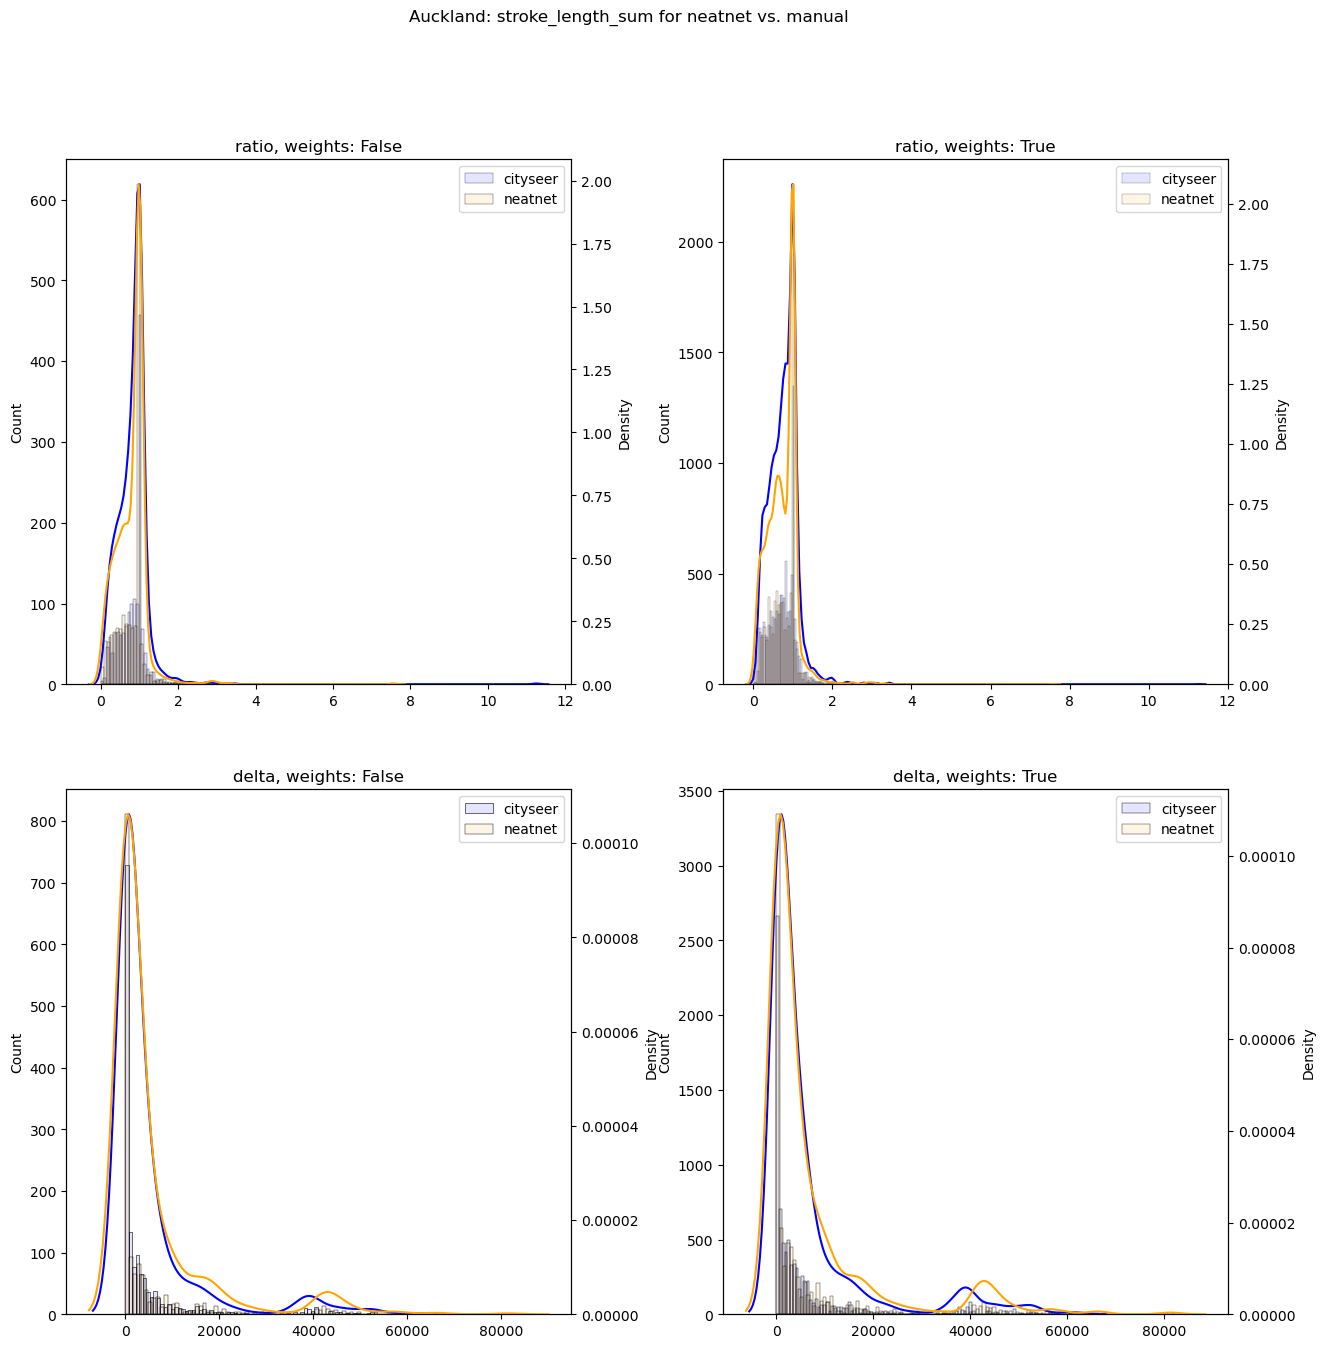

In [98]:
# deltas.rank_weight is used to WEIGH the data
# evaldict[m1m2] is used to get the _ratio and _abs columns

# for a given evaluation variable:
eval_var = eval_vars[-2]

# make 2x2 plot
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
plt.suptitle(f"{city}: {eval_var} for {m1} vs. {m2}")


for mycolor, methodpair, twinax_exclude in zip(
    ["blue", "orange"],
    [methodpairs_to_compare[0], methodpairs_to_compare[-1]],
    [True, False],
    strict=False,
):
    m1, m2 = methodpair
    for ax, comp, weights in zip(
        [axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]],
        ["ratio", "ratio", "delta", "delta"],
        [False, True, False, True],
        strict=False,
    ):
        data = get_data(
            evaldict=evaldict,
            methodpair=methodpair,
            eval_var=eval_var,
            comp=comp,
            weights=weights,
            deltas=deltas,
        )
        sns.histplot(
            ax=ax,
            data=data,
            color=mycolor,
            alpha=0.1,
            label=m1,
        )
        twinax = ax.twinx()
        sns.kdeplot(
            ax=twinax,
            data=data,
            color=mycolor,
            # alpha=0.5
        )
        if twinax_exclude:
            twinax.set_axis_off()
        ax.set_title(f"{comp}, weights: {weights}")
for ax in [axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]]:
    ax.legend()

plt.subplots_adjust(wspace=0.3)
plt.show()